In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [46]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [47]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [48]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [49]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [50]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [51]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-51-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [52]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-52-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [53]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [54]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [55]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(3285, 4, 32, 9) (1387, 4, 32, 9)


In [61]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [16]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [18]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 30, 64)      1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               4

In [19]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 13s 184ms/step - loss: 0.9799 - accuracy: 0.5209 - val_loss: 0.7156 - val_accuracy: 0.7363
Epoch 2/10
26/26 [==============================] - 3s 122ms/step - loss: 0.5477 - accuracy: 0.7839 - val_loss: 0.3674 - val_accuracy: 0.8813
Epoch 3/10
26/26 [==============================] - 4s 172ms/step - loss: 0.2500 - accuracy: 0.9129 - val_loss: 0.1826 - val_accuracy: 0.9462
Epoch 4/10
26/26 [==============================] - 4s 155ms/step - loss: 0.1511 - accuracy: 0.9479 - val_loss: 0.0725 - val_accuracy: 0.9838
Epoch 5/10
26/26 [==============================] - 4s 138ms/step - loss: 0.0707 - accuracy: 0.9790 - val_loss: 0.0403 - val_accuracy: 0.9939
Epoch 6/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0651 - accuracy: 0.9784 - val_loss: 0.0238 - val_accuracy: 0.9970
Epoch 7/10
26/26 [==============================] - 2s 68ms/step - loss: 0.0480 - accuracy: 0.9833 - val_loss: 0.0293 - val_accuracy: 0.9959
Epoch 8

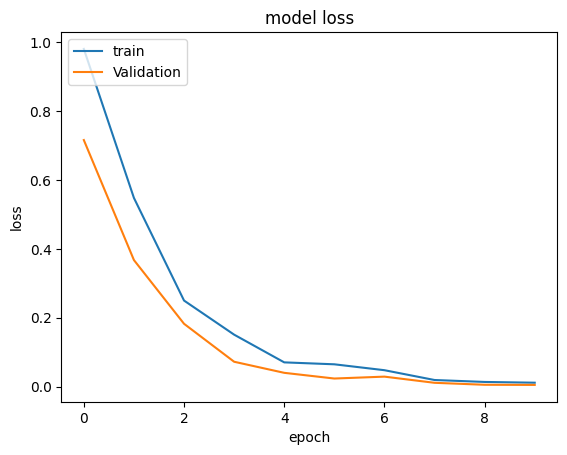

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

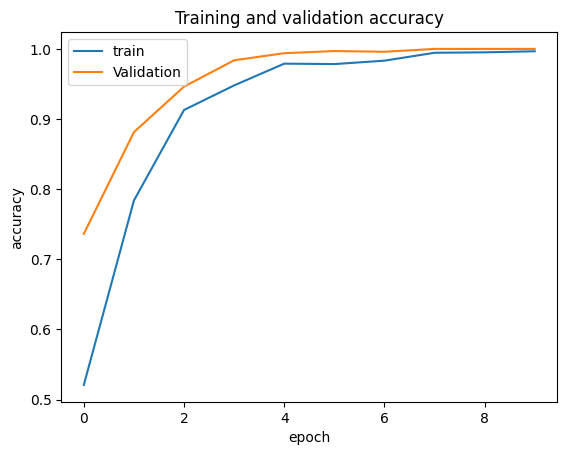

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 12ms/step
[[458   1  37]
 [  2 441  28]
 [  6   1 413]]
0.9459264599855803
0.9467323418512902
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       1.00      0.94      0.96       471
           2       0.86      0.98      0.92       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

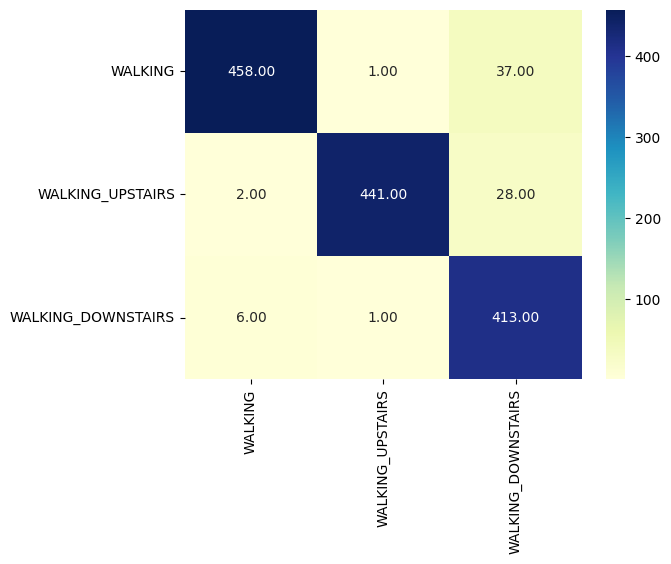

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 - LSTM2

In [36]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 100)              

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 6s 112ms/step - loss: 0.9611 - accuracy: 0.5339 - val_loss: 0.6679 - val_accuracy: 0.7830
Epoch 2/10
26/26 [==============================] - 2s 65ms/step - loss: 0.4732 - accuracy: 0.8283 - val_loss: 0.3022 - val_accuracy: 0.8945
Epoch 3/10
26/26 [==============================] - 2s 80ms/step - loss: 0.1957 - accuracy: 0.9364 - val_loss: 0.1091 - val_accuracy: 0.9746
Epoch 4/10
26/26 [==============================] - 4s 146ms/step - loss: 0.0898 - accuracy: 0.9702 - val_loss: 0.0475 - val_accuracy: 0.9909
Epoch 5/10
26/26 [==============================] - 3s 115ms/step - loss: 0.0563 - accuracy: 0.9823 - val_loss: 0.0444 - val_accuracy: 0.9868
Epoch 6/10
26/26 [==============================] - 2s 95ms/step - loss: 0.0491 - accuracy: 0.9863 - val_loss: 0.0193 - val_accuracy: 0.9990
Epoch 7/10
26/26 [==============================] - 3s 105ms/step - loss: 0.0201 - accuracy: 0.9954 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 8/1

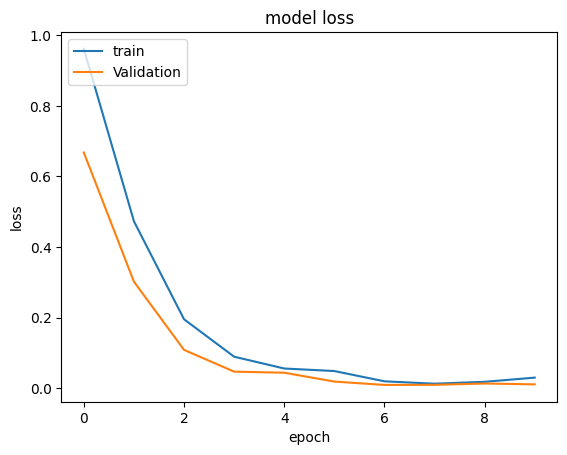

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

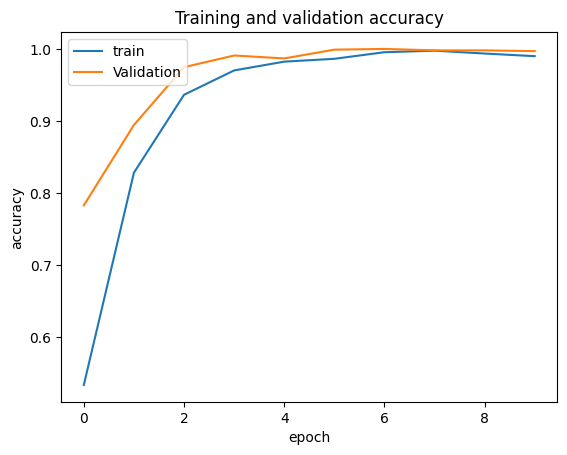

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 7ms/step
[[451  19  26]
 [  0 447  24]
 [  6  19 395]]
0.9322278298485941
0.9325841695959991
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       496
           1       0.92      0.95      0.94       471
           2       0.89      0.94      0.91       420

    accuracy                           0.93      1387
   macro avg       0.93      0.93      0.93      1387
weighted avg       0.93      0.93      0.93      1387



<Axes: >

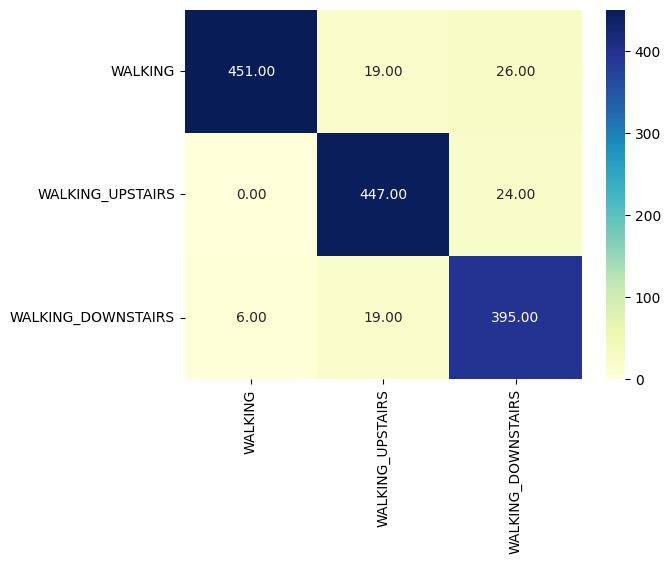

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [26]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 896)        

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 7s 133ms/step - loss: 0.8761 - accuracy: 0.5714 - val_loss: 0.5236 - val_accuracy: 0.8114
Epoch 2/10
26/26 [==============================] - 4s 170ms/step - loss: 0.3906 - accuracy: 0.8600 - val_loss: 0.2218 - val_accuracy: 0.9533
Epoch 3/10
26/26 [==============================] - 4s 153ms/step - loss: 0.1523 - accuracy: 0.9537 - val_loss: 0.1074 - val_accuracy: 0.9736
Epoch 4/10
26/26 [==============================] - 2s 91ms/step - loss: 0.1504 - accuracy: 0.9482 - val_loss: 0.1181 - val_accuracy: 0.9594
Epoch 5/10
26/26 [==============================] - 2s 91ms/step - loss: 0.0521 - accuracy: 0.9851 - val_loss: 0.0247 - val_accuracy: 0.9980
Epoch 6/10
26/26 [==============================] - 2s 96ms/step - loss: 0.0320 - accuracy: 0.9884 - val_loss: 0.0385 - val_accuracy: 0.9919
Epoch 7/10
26/26 [==============================] - 4s 153ms/step - loss: 0.0287 - accuracy: 0.9918 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 8/1

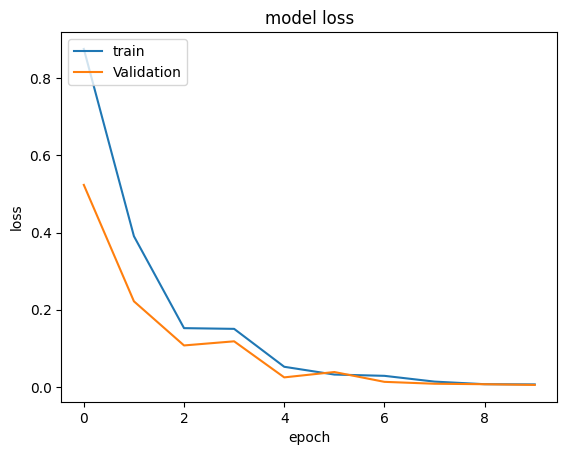

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

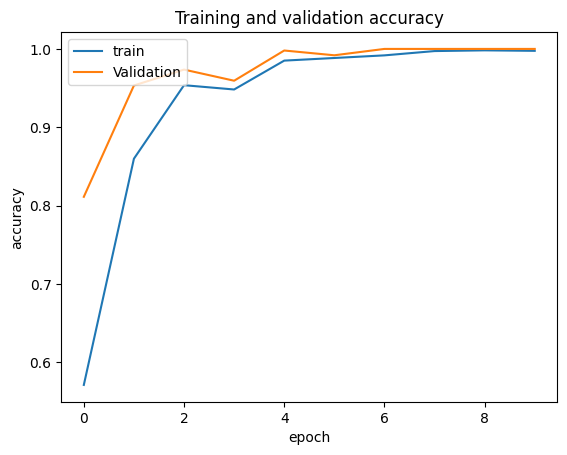

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 9ms/step
[[431   4  61]
 [  2 436  33]
 [  1   0 419]]
0.9271809661139149
0.9284819780029935
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       496
           1       0.99      0.93      0.96       471
           2       0.82      1.00      0.90       420

    accuracy                           0.93      1387
   macro avg       0.93      0.93      0.93      1387
weighted avg       0.94      0.93      0.93      1387



<Axes: >

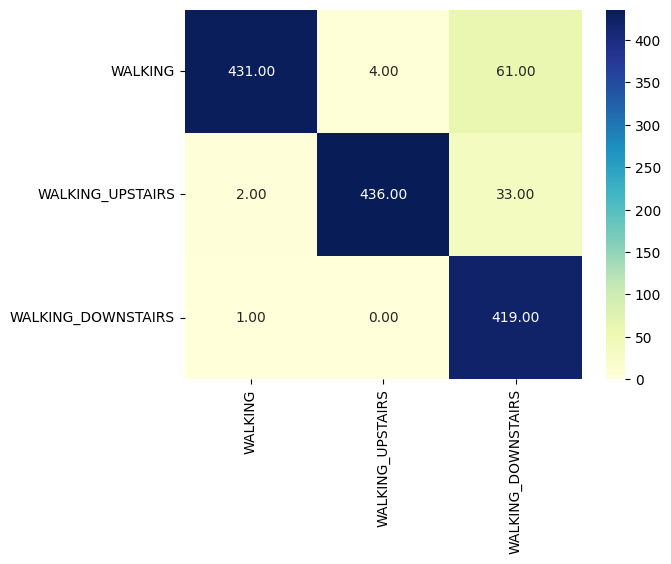

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2-LSTM2


In [31]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_23 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_24 (TimeD  (None, None, 896)        

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 11s 151ms/step - loss: 1.0342 - accuracy: 0.4706 - val_loss: 0.8345 - val_accuracy: 0.6471
Epoch 2/10
26/26 [==============================] - 3s 104ms/step - loss: 0.6093 - accuracy: 0.7440 - val_loss: 0.4164 - val_accuracy: 0.8377
Epoch 3/10
26/26 [==============================] - 3s 108ms/step - loss: 0.2812 - accuracy: 0.9011 - val_loss: 0.1260 - val_accuracy: 0.9726
Epoch 4/10
26/26 [==============================] - 4s 148ms/step - loss: 0.1219 - accuracy: 0.9580 - val_loss: 0.0552 - val_accuracy: 0.9929
Epoch 5/10
26/26 [==============================] - 4s 137ms/step - loss: 0.0552 - accuracy: 0.9839 - val_loss: 0.0260 - val_accuracy: 0.9970
Epoch 6/10
26/26 [==============================] - 3s 126ms/step - loss: 0.0470 - accuracy: 0.9830 - val_loss: 0.0239 - val_accuracy: 0.9990
Epoch 7/10
26/26 [==============================] - 3s 101ms/step - loss: 0.0284 - accuracy: 0.9921 - val_loss: 0.0162 - val_accuracy: 0.9980
Epoch

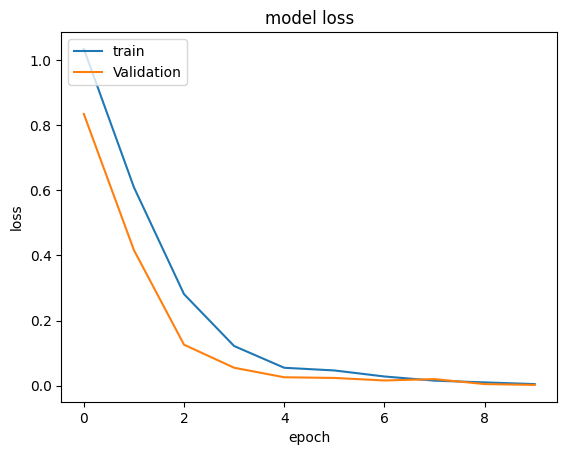

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

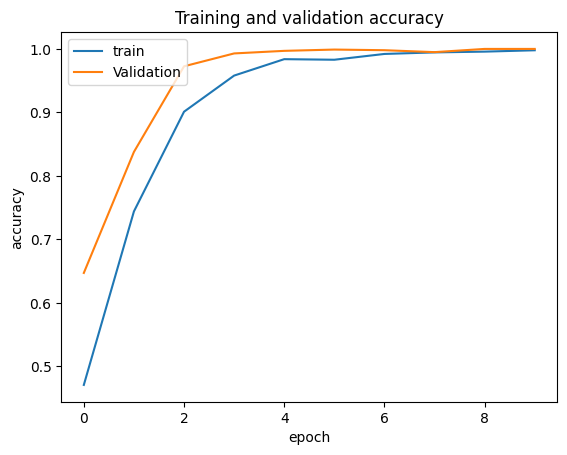

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 11ms/step
[[459   9  28]
 [  7 439  25]
 [  5   2 413]]
0.9452054794520548
0.9455183358245441
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       496
           1       0.98      0.93      0.95       471
           2       0.89      0.98      0.93       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.94      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

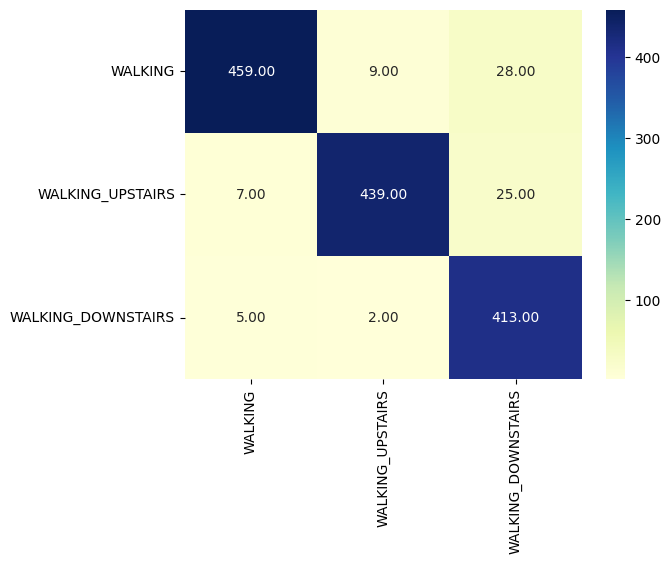

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')